In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
raw_data_path=os.path.join('data','raw')
df=pd.read_csv(os.path.join(raw_data_path,'fer2013.csv'))
X=[]
for i in range(len(df)):
    X.append(df.loc[i,'pixels'].split(' '))
X=np.array(X,np.float32)/255.
y=df.emotion.values
X_train=X[np.where(df.Usage=='Training')]
y_train=y[np.where((df.Usage=='Training'))]
X_test=X[np.where((df.Usage!='Training'))]
y_test=y[np.where((df.Usage!='Training'))]
def balance_classes(X,y):
    X1=X[np.where(y!=1)]
    X2=X[np.where(y==1)]
    X2=np.repeat(X2,9,axis=0)
    X=np.concatenate((X1,X2),axis=0)
    y1=y[np.where(y!=1)]
    y2=y[np.where(y==1)]
    y2=np.repeat(y2,9,axis=0)
    y=np.concatenate((y1,y2),axis=0)
    i=[i for i in range(len(y))]
    np.random.shuffle(i)
    return X[i],y[i]
X_train,y_train=balance_classes(X_train,y_train)
def one_hot_encoder(X):
    N=len(X)
    K=len(set(X))
    Z=np.zeros((N,K))
    for i in range(N):
        c=X[i]
        Z[i,c]=1
    return Z
y_train=one_hot_encoder(y_train)

In [16]:
class ANN(object):
    def __init__(self,lr,epoch,hu):
        self.lr=lr
        self.epoch=epoch
        self.hu=hu
    def relu(self,z):
        return z*(z>0)
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def softmax(self,a):
        return np.exp(a)/(np.exp(a).sum(axis=1,keepdims=True))
    def forward(self,X,W1,b1,W2,b2):
        z=self.relu(X.dot(W1)+b1)
#         return z,self.sigmoid(z.dot(W2)+b2)
        return z,self.softmax(z.dot(W2)+b2)
    def cost(self,y,y_p):
#         return -(y*np.log(y_p)+(1-y)*np.log(1-y_p)).sum()
        return -(y*np.log(y_p)).sum()
    def fit(self,X,y,fig=False):
        N,D=X.shape
        K=y.shape[1]
        W1=np.random.randn(D,self.hu)
        b1=np.random.randn(self.hu)
        W2=np.random.randn(self.hu,K)
        b2=np.random.randn(K)
        tr_i=np.random.choice(N,int(N*0.9),replace=False)
        t_i=[i for i in range(N) if i not in tr_i]
        X_t=X[tr_i]
        y_t=y[tr_i]
        X_v=X[t_i]
        y_v=y[t_i]
        c_t=[]
        c_v=[]
        cl_t=[]
        cl_v=[]
        for i in range(self.epoch):
            z,y_p_t=self.forward(X_t,W1,b1,W2,b2)
            _,y_p_v=self.forward(X_v,W1,b1,W2,b2)
            dy=y_p_t-y_t
            W2=W2-self.lr*(z.T.dot(dy))
            b2=b2-self.lr*(dy).sum(axis=0)
            dz=dy.dot(W2.T)*(z>0)
            W1=W1-self.lr*X_t.T.dot(dz)
            b1=b1-self.lr*(dz).sum(axis=0)
            c_t.append(self.cost(y_t,y_p_t))
            c_v.append(self.cost(y_v,y_p_v))
            cl_t.append(np.mean(y_t.argmax(axis=1)==(y_p_t.argmax(axis=1))))
            cl_v.append(np.mean(y_v.argmax(axis=1)==(y_p_v.argmax(axis=1))))
            if i % 100==0:
                print('Epoch {0} Train Cost , Classification : {1}  , {2} Test Cost , Classification : {3}  , {4}'.format(i,
                                                                                                                          c_t[i],
                                                                                                                         cl_t[i],
                                                                                                                         c_v[i],
                                                                                                                         cl_v[i]))
        self.W2=W2
        self.W1=W1
        self.b2=b2
        self.b1=b1
        self.c_t=c_t
        self.c_v=c_v
        self.cl_t=cl_t
        self.cl_v=cl_v
        if fig==True:
            plt.plot(c_t,label='Train Cost')
            plt.plot(c_v,label='Test Cost')
            plt.show()
            plt.plot(cl_t,label='Train Class')
            plt.plot(cl_v,label='Test Class')
            plt.show()
    def predict(self,X):
        _,y_p=self.forward(X,self.W1,self.b1,self.W2,self.b2)
        return (y_p).argmax(axis=1)
    def score(self,y,y_p):
        return np.mean(y==y_p)


In [17]:
ann=ANN(0.0000001,1000,5)

Epoch 0 Train Cost , Classification : 1917074.0407930047  , 0.10270214307899368 Test Cost , Classification : 211516.13013447553  , 0.10434782608695652
Epoch 100 Train Cost , Classification : 93796.25792790978  , 0.11226144873520379 Test Cost , Classification : 10206.002266135027  , 0.11490683229813664
Epoch 200 Train Cost , Classification : 77845.12958452787  , 0.10497981157469717 Test Cost , Classification : 8363.90031939311  , 0.10683229813664596
Epoch 300 Train Cost , Classification : 73112.93960790131  , 0.10256410256410256 Test Cost , Classification : 7867.329035118442  , 0.10279503105590063
Epoch 400 Train Cost , Classification : 70467.47918529871  , 0.10183938986092418 Test Cost , Classification : 7625.495656414239  , 0.10248447204968944
Epoch 500 Train Cost , Classification : 68711.03043429393  , 0.10132173793008248 Test Cost , Classification : 7465.537398438161  , 0.10186335403726708
Epoch 600 Train Cost , Classification : 67385.1684849123  , 0.10087310625668634 Test Cost , Cl

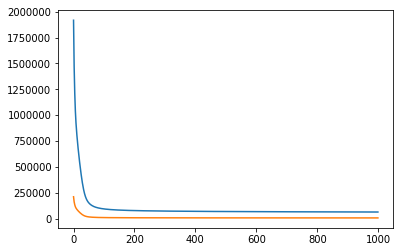

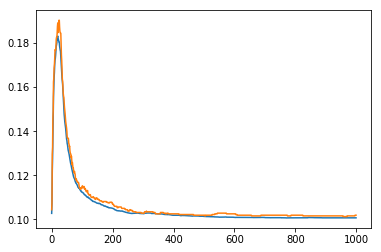

In [18]:
ann.fit(X_train,y_train,fig=True)

In [8]:
y_train[[1,2,3,4]]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]])